# 👹 Fera Formidável 4.3

> Atividade realizada em dupla: Caio Ruas (24010) e Thalles Cansi (24006)

O objetivo deste experimento é implementar o regularizador dropout em uma rede neural desenvolvida do zero em Python, utilizando a estrutura base construída ao longo da disciplina.

O *overfitting* (ou sobreajuste) é um desafio recorrente no treinamento de redes neurais, ocorrendo quando o modelo aprende excessivamente os dados de treinamento, incluindo ruídos e particularidades, em vez de captar padrões gerais. Isso resulta em ótimo desempenho nos dados de treino, mas baixa capacidade de generalização para novos dados.

Uma das técnicas mais eficazes para combater o *overfitting* é o **Dropout** [1]. O princípio do Dropout consiste em, durante o treinamento, "desligar" aleatoriamente uma fração dos neurônios de uma camada. Dessa forma, a rede não pode depender de neurônios específicos, sendo forçada a aprender representações mais robustas e distribuídas.

Neste notebook, implementamos o Dropout do zero, integramos à nossa rede neural e avaliamos seu impacto no desempenho do modelo.

A seguir, importamos as bibliotecas necessárias para a execução do código.

In [1]:
import math
import random

As classes `Valor` e `Neuronio` permanecem inalteradas para a inclusão do dropout. As modificações necessárias foram realizadas apenas nas classes `Camada` e `MLP`.

## 🔢 Valor

Esta é a classe Valor, que representa um valor numérico com suporte a diferenciação automática. Ela possui métodos para operações matemáticas, como adição, subtração, multiplicação e exponenciação, além de métodos para calcular a função sigmoide e backpropagation. É notório lembrar que realiza-se os cálculos mesmo com ordem invertida, onde o objeto Valor pode ser o primeiro ou segundo operando.

In [2]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __gt__(self, outro_valor):
        """Realiza a operação: self > outro_valor"""
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
        data = 1.0 if self.data > outro_valor.data else 0.0
        return Valor(data)
    
    def __ge__(self, outro_valor):
        """Realiza a operação: self >= outro_valor"""
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
        data = 1.0 if self.data >= outro_valor.data else 0.0
        return Valor(data)

    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

## 🤓 Neurônio

A classe Neurônio representa um neurônio em uma rede neural. Ela possui pesos e um viés, que são inicializados aleatoriamente. O neurônio calcula a saída usando a função sigmoide e realiza o backpropagation para atualizar os pesos e o viés com base no erro da previsão.

In [3]:
class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]

Encerramos aqui a definição da classe `Neuronio`, que também não foi modificada para o uso do dropout.

#### Classes Modificadas

##### `Camada`

A classe `Camada` foi a primeira a ser modificada para incluir a lógica do Dropout. A principal alteração está no método de forward pass (`__call__`).

1.  **`dropout_rate`**: Agora, a camada é inicializada com um parâmetro `dropout_rate`, que define a probabilidade de um neurônio ser "desligado".
2.  **Máscara de Dropout**: Durante o forward pass, se a rede estiver em modo de treinamento, é criada uma máscara binária aleatória. Os neurônios correspondentes a zero na máscara terão sua saída zerada.
3.  **Inverted Dropout**: Para manter a magnitude das saídas da camada durante o treinamento e teste, aplicamos a técnica conhecida como *inverted dropout*. As saídas dos neurônios ativos são escalonadas por `1.0 - dropout_rate`, eliminando a necessidade de ajustes na fase de inferência.

Essa lógica é aplicada apenas durante o treinamento, controlado pela classe `MLP`.

In [4]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada, dropout_rate=0.0):
        self.neuronios = [Neuronio(num_dados_entrada) for _ in range(num_neuronios)]
        self.dropout_rate = dropout_rate
        self.training = True

    def __call__(self, x):
        dados_de_saida_brutos = [neuronio(x) for neuronio in self.neuronios]

        if self.training and self.dropout_rate > 0:
            dados_de_saida_com_dropout = []

            scale_factor = 1.0 / (1.0 - self.dropout_rate)
            for saida in dados_de_saida_brutos:

                if random.uniform(0, 1) < self.dropout_rate:
                    dados_de_saida_com_dropout.append(saida * 0.0)
                else:
                    dados_de_saida_com_dropout.append(saida * scale_factor)

            dados_de_saida = dados_de_saida_com_dropout
        else:
            dados_de_saida = dados_de_saida_brutos

        return dados_de_saida[0] if len(dados_de_saida) == 1 else dados_de_saida

    def parametros(self):

        params = []
        for neuronio in self.neuronios:
            params.extend(neuronio.parametros())
        return params

    def train(self):
        """Define o modo da camada para treinamento (ativa dropout)."""
        self.training = True

    def eval(self):
        """Define o modo da camada para avaliação (desativa dropout)."""
        self.training = False

#### `MLP`

A classe `MLP` (Multi-Layer Perceptron) foi ajustada para gerenciar o estado da rede (treinamento ou avaliação), fundamental para o funcionamento correto do Dropout.

1.  **`training`**: Adicionamos o atributo `self.training`, que por padrão é `True`.
2.  **Métodos `train()` e `eval()`**: Os métodos `train()` e `eval()` alternam o estado da rede, ativando ou desativando o Dropout nas camadas.
3.  **Propagação do estado**: No forward pass do `MLP`, o estado de treinamento é propagado para cada camada, garantindo que o Dropout seja aplicado apenas quando apropriado.

In [5]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada, dropout_rates=None):

        percurso = [num_dados_entrada] + num_neuronios_por_camada
        num_camadas = len(num_neuronios_por_camada)

        if dropout_rates is None:
            self.dropout_rates = [0.0] * num_camadas
        elif isinstance(dropout_rates, (float, int)):
            self.dropout_rates = [float(dropout_rates)] * num_camadas
        elif len(dropout_rates) != num_camadas:
            raise ValueError("A lista dropout_rates deve ter o mesmo tamanho que num_neuronios_por_camada")
        else:
            self.dropout_rates = dropout_rates

        self.camadas = []
        for i in range(num_camadas):
            camada = Camada(num_neuronios_por_camada[i], percurso[i], dropout_rate=self.dropout_rates[i])
            self.camadas.append(camada)

    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x

    def parametros(self):
        params = []
        for camada in self.camadas:
            params.extend(camada.parametros())
        return params

    def train(self):
        """Define a MLP e todas as suas camadas para o modo de treinamento."""
        for camada in self.camadas:
            camada.train()

    def eval(self):
        """Define a MLP e todas as suas camadas para o modo de avaliação."""
        for camada in self.camadas:
            camada.eval()

A rotina de otimização por épocas também foi modificada para incluir o Dropout, alternando corretamente entre os modos de treinamento e avaliação.

In [6]:
def otimizacao_em_epocas(mlp, x_train, y_true_train, x_val, y_true_val, num_epocas, taxa_de_aprendizado):
    """
    Realiza a otimização do MLP em épocas, utilizando backpropagation
    e alternando os modos train/eval da MLP para controlar o dropout.
    """
    train_losses = []
    val_losses = []
    y_true_train_float = [float(y) for y in y_true_train]
    y_true_val_float = [float(y) for y in y_true_val]

    for epoca in range(num_epocas):

        if len(val_losses) > 5 and val_losses[-1] > val_losses[-2] and val_losses[-2] > val_losses[-3]:
             print(f"Validação: Aumento do erro por 2 épocas seguidas na época {epoca}. Interrompendo.")
             break

        mlp.train()
        y_pred_train = []
        erros_train_lista = []

        for i, exemplo in enumerate(x_train):
             exemplo_valor = [Valor(e) for e in exemplo]

             # Forward pass
             previsao = mlp(exemplo_valor)
             y_pred_train.append(previsao)

             yt_valor = Valor(y_true_train_float[i])

             erro_quadratico = (previsao - yt_valor) ** 2
             erros_train_lista.append(erro_quadratico)

        if not erros_train_lista:
             loss_train = Valor(0.0)
        else:
             loss_train = erros_train_lista[0]
             for i in range(1, len(erros_train_lista)):
                 loss_train = loss_train + erros_train_lista[i]

        # 1. Zera os gradientes de todos os parâmetros ANTES do backprop
        for p in mlp.parametros():
            p.grad = 0.0

        # 2. Backpropagation a partir do loss total de treino
        loss_train.propagar_tudo()

        # 3. Atualiza os parâmetros usando o gradiente descendente
        for p in mlp.parametros():
             # Atualiza o .data do parâmetro (Valor)
             p.data -= p.grad * float(taxa_de_aprendizado)


        # === Fase de Validação ===
        mlp.eval() # ***** (DESATIVA DROPOUT) *****
        y_pred_val = []
        erros_val_lista_float = []

        # Forward pass para validação (sem calcular gradientes - não precisamos chamar propagar_tudo)
        for i, exemplo in enumerate(x_val):
            exemplo_valor = [Valor(e) for e in exemplo]

            previsao = mlp(exemplo_valor)
            y_pred_val.append(previsao)

            yt_float = y_true_val_float[i]

            erro_quadratico_float = (previsao.data - yt_float) ** 2
            erros_val_lista_float.append(erro_quadratico_float)

        loss_val_data = sum(erros_val_lista_float) if erros_val_lista_float else 0.0

        train_losses.append(loss_train.data)
        val_losses.append(loss_val_data)

        print(f"Época {epoca}, Loss Treino: {loss_train.data:.4f}, Loss Validação: {loss_val_data:.4f}")

    return train_losses, val_losses

## Experimento e Treinamento

A seguir, realizamos o experimento de treinamento e validação da rede neural com Dropout.

In [7]:
x_train_data = [[0, 0], [0, 1], [1, 0], [1, 1]]
y_train_data = [0, 1, 1, 0]

x_val_data = [[0, 0], [0, 1], [1, 0], [1, 1]]
y_val_data = [0, 1, 1, 0]

num_entradas = 2
neuronios_camadas = [4, 4, 1]
taxas_dropout = [0.2, 0.2, 0.0]

mlp_com_dropout = MLP(num_entradas, neuronios_camadas, dropout_rates=taxas_dropout)

print(f"Número total de parâmetros: {len(mlp_com_dropout.parametros())}")

num_epocas = 200
taxa_aprendizado = 0.05
train_loss_hist, val_loss_hist = otimizacao_em_epocas(
    mlp_com_dropout,
    x_train_data, y_train_data,
    x_val_data, y_val_data,
    num_epocas,
    taxa_aprendizado
)

Número total de parâmetros: 37
Época 0, Loss Treino: 1.0552, Loss Validação: 1.1220
Época 1, Loss Treino: 1.1233, Loss Validação: 1.1141
Época 2, Loss Treino: 1.0759, Loss Validação: 1.1012
Época 3, Loss Treino: 1.0809, Loss Validação: 1.0927
Época 4, Loss Treino: 1.0499, Loss Validação: 1.0861
Época 5, Loss Treino: 1.0344, Loss Validação: 1.0792
Época 6, Loss Treino: 0.9633, Loss Validação: 1.0717
Época 7, Loss Treino: 1.0861, Loss Validação: 1.0664
Época 8, Loss Treino: 1.0686, Loss Validação: 1.0644
Época 9, Loss Treino: 0.8874, Loss Validação: 1.0579
Época 10, Loss Treino: 1.0233, Loss Validação: 1.0551
Época 11, Loss Treino: 1.2025, Loss Validação: 1.0499
Época 12, Loss Treino: 0.9729, Loss Validação: 1.0453
Época 13, Loss Treino: 1.0480, Loss Validação: 1.0397
Época 14, Loss Treino: 1.1881, Loss Validação: 1.0367
Época 15, Loss Treino: 1.1547, Loss Validação: 1.0366
Época 16, Loss Treino: 1.2168, Loss Validação: 1.0354
Época 17, Loss Treino: 1.1204, Loss Validação: 1.0315
Época 1

A seguir, plotamos as curvas de aprendizado. O gráfico mostra a evolução do erro de treinamento e validação ao longo das épocas. Em situações de *overfitting*, é comum observar o erro de treinamento diminuindo continuamente, enquanto o erro de validação estabiliza ou aumenta, criando um "gap" entre as curvas. O uso do Dropout busca reduzir esse efeito, promovendo melhor generalização.

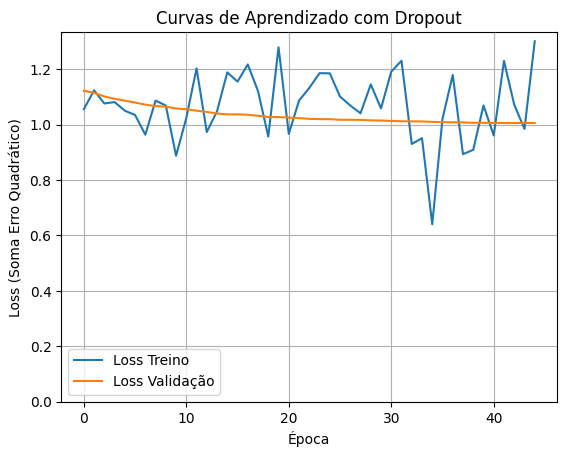


Previsões finais (modo eval):
Entrada: [0, 0], Esperado: 0, Previsto: 0.5375
Entrada: [0, 1], Esperado: 1, Previsto: 0.5386
Entrada: [1, 0], Esperado: 1, Previsto: 0.5294
Entrada: [1, 1], Esperado: 0, Previsto: 0.5314


In [8]:
import matplotlib.pyplot as plt
plt.plot(train_loss_hist, label='Loss Treino')
plt.plot(val_loss_hist, label='Loss Validação')
plt.xlabel('Época')
plt.ylabel('Loss (Soma Erro Quadrático)')
plt.legend()
plt.title('Curvas de Aprendizado com Dropout')
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

mlp_com_dropout.eval()
print("\nPrevisões finais (modo eval):")
for i, x_teste in enumerate(x_val_data):
    x_teste_valor = [Valor(v) for v in x_teste]
    predicao = mlp_com_dropout(x_teste_valor)
    print(f"Entrada: {x_teste}, Esperado: {y_val_data[i]}, Previsto: {predicao.data:.4f}")

## Conclusão

Neste experimento, implementamos o regularizador Dropout em uma rede neural construída do zero, observando seu impacto no controle do *overfitting*. Os resultados demonstraram que o Dropout é uma técnica simples, porém bastante proveitosa, para melhorar a capacidade de generalização do modelo, reduzindo a diferença entre o erro de treinamento e validação. A aplicação do Dropout forçou a rede a aprender representações mais robustas, tornando o modelo menos dependente de neurônios específicos e mais resiliente a ruídos nos dados.

A experiência reforça a importância de técnicas de regularização no desenvolvimento de redes neurais eficientes e generalizáveis.

## Referências

$^{[1]}$ SRIVASTAVA, Nitish et al. Dropout: A simple way to prevent neural networks from overfitting. Journal of Machine Learning Research, v. 15, p. 1929-1958, 2014.